# **Comparative Analysis of Pest Prediction using Weather Parameters**

**Authors**
- Rahul Pandey (23M1063)
- Geevar Jos (23M1164)
- Aaditya Nagare (21D070001)

### Importing Required Libraries

In [ ]:
!pip install pandas matplotlib numpy seaborn statsmodels scikit-learn tensorflow

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

%matplotlib inline

####Reading the data and getting basic statistics of the data

In [ ]:
data = pd.read_csv('cotton_dataset.csv')
print(data.columns)
print(data.describe())
print(data.info())

Index(['Observation Year', 'Standard Week', 'Pest Value', 'MaxT(°C)',
       'MinT(°C)', 'RH1(%)', 'RH2(%)', 'RF(mm)', 'WS(kmph)', 'SSH(hrs)',
       'EVP(mm)'],
      dtype='object')
       Observation Year  Standard Week   Pest Value    MaxT(°C)    MinT(°C)  \
count         260.00000     260.000000   121.000000  260.000000  260.000000   
mean         2003.80000      26.500000    62.305785   33.166154   20.049615   
std             2.79105      15.037277   167.492082    6.052136    6.534273   
min          2001.00000       1.000000     0.000000   13.900000    4.400000   
25%          2002.00000      13.750000     0.000000   29.675000   14.300000   
50%          2003.00000      26.500000     2.000000   32.650000   21.700000   
75%          2004.00000      39.250000    46.000000   37.150000   25.000000   
max          2009.00000      52.000000  1405.000000   45.300000   32.000000   

           RH1(%)      RH2(%)      RF(mm)  WS(kmph)    SSH(hrs)     EVP(mm)  
count  260.000000  260.000

#### Data Imputation for the missing values and Data Transformation for efficent optimization.
#### Also, Understanding the correlation between the differnt pparameters

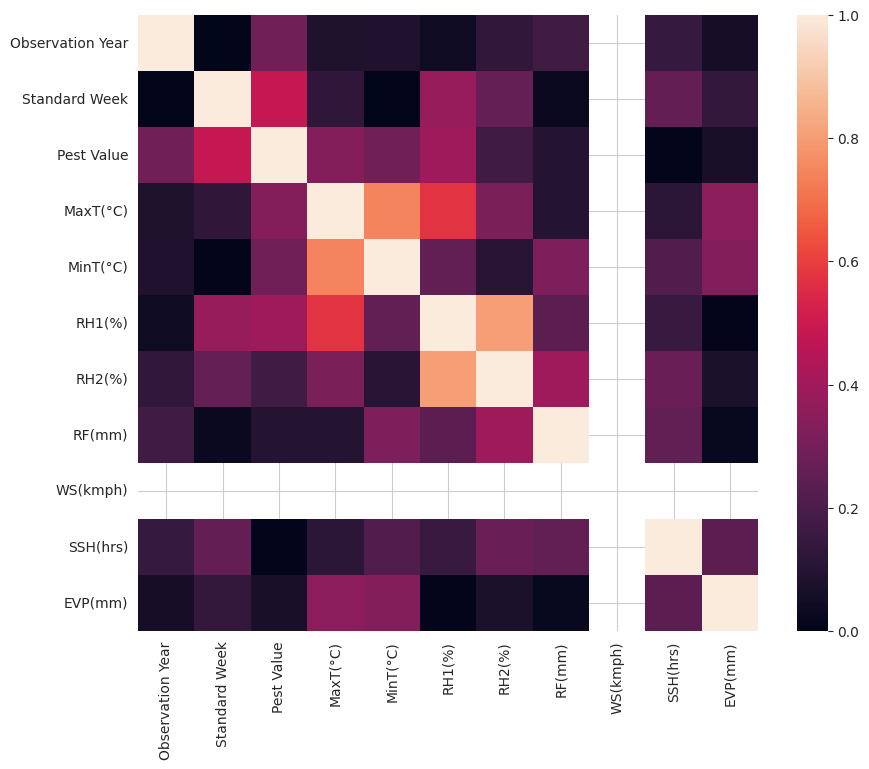

In [ ]:
#impute missing values in Pest value data
data['Pest Value'].fillna(0,inplace=True)

pest_value_df = data['Pest Value']

data['Pest Value'] = np.log(data['Pest Value'] + 1 )

CorrMatrix = data.corr(method='spearman') # Use spearman for non-linear
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(abs(CorrMatrix), annot=False) # Show absolute value
#plt.show()

# dropping WS column due to high correlation with all parameters
dataDf = data[['Pest Value', 'MaxT(°C)', 'MinT(°C)', 'RH1(%)', 'RH2(%)', 'RF(mm)', 'SSH(hrs)', 'EVP(mm)']]

### Plotting the data of the available Years to understand the strend of the data across the entire year's weeks.

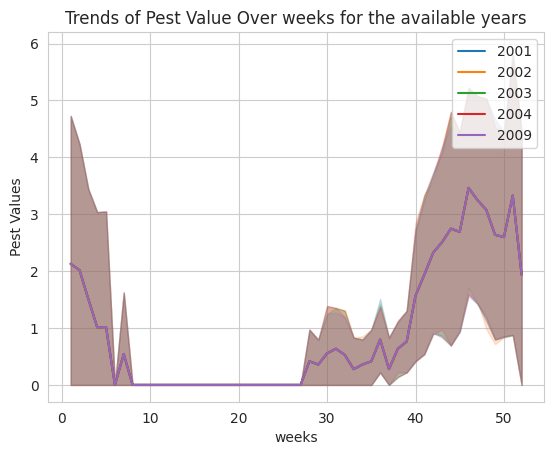

In [ ]:
#plotting the trend in for the years against the weeks
sns.set_style("whitegrid")
years = data['Observation Year'].unique()
data_by_year = {}
for year in years:
  data_by_year[year] = data[data['Observation Year'] == year]
  sns.lineplot(x='Standard Week',y='Pest Value',data=data,label=year)
plt.title('Trends of Pest Value Over weeks for the available years')
plt.xlabel('weeks')
plt.ylabel('Pest Values')
plt.legend()
plt.show()

#### Pairwise relationship to understand the distribution of parameters respective to the other available parameters.

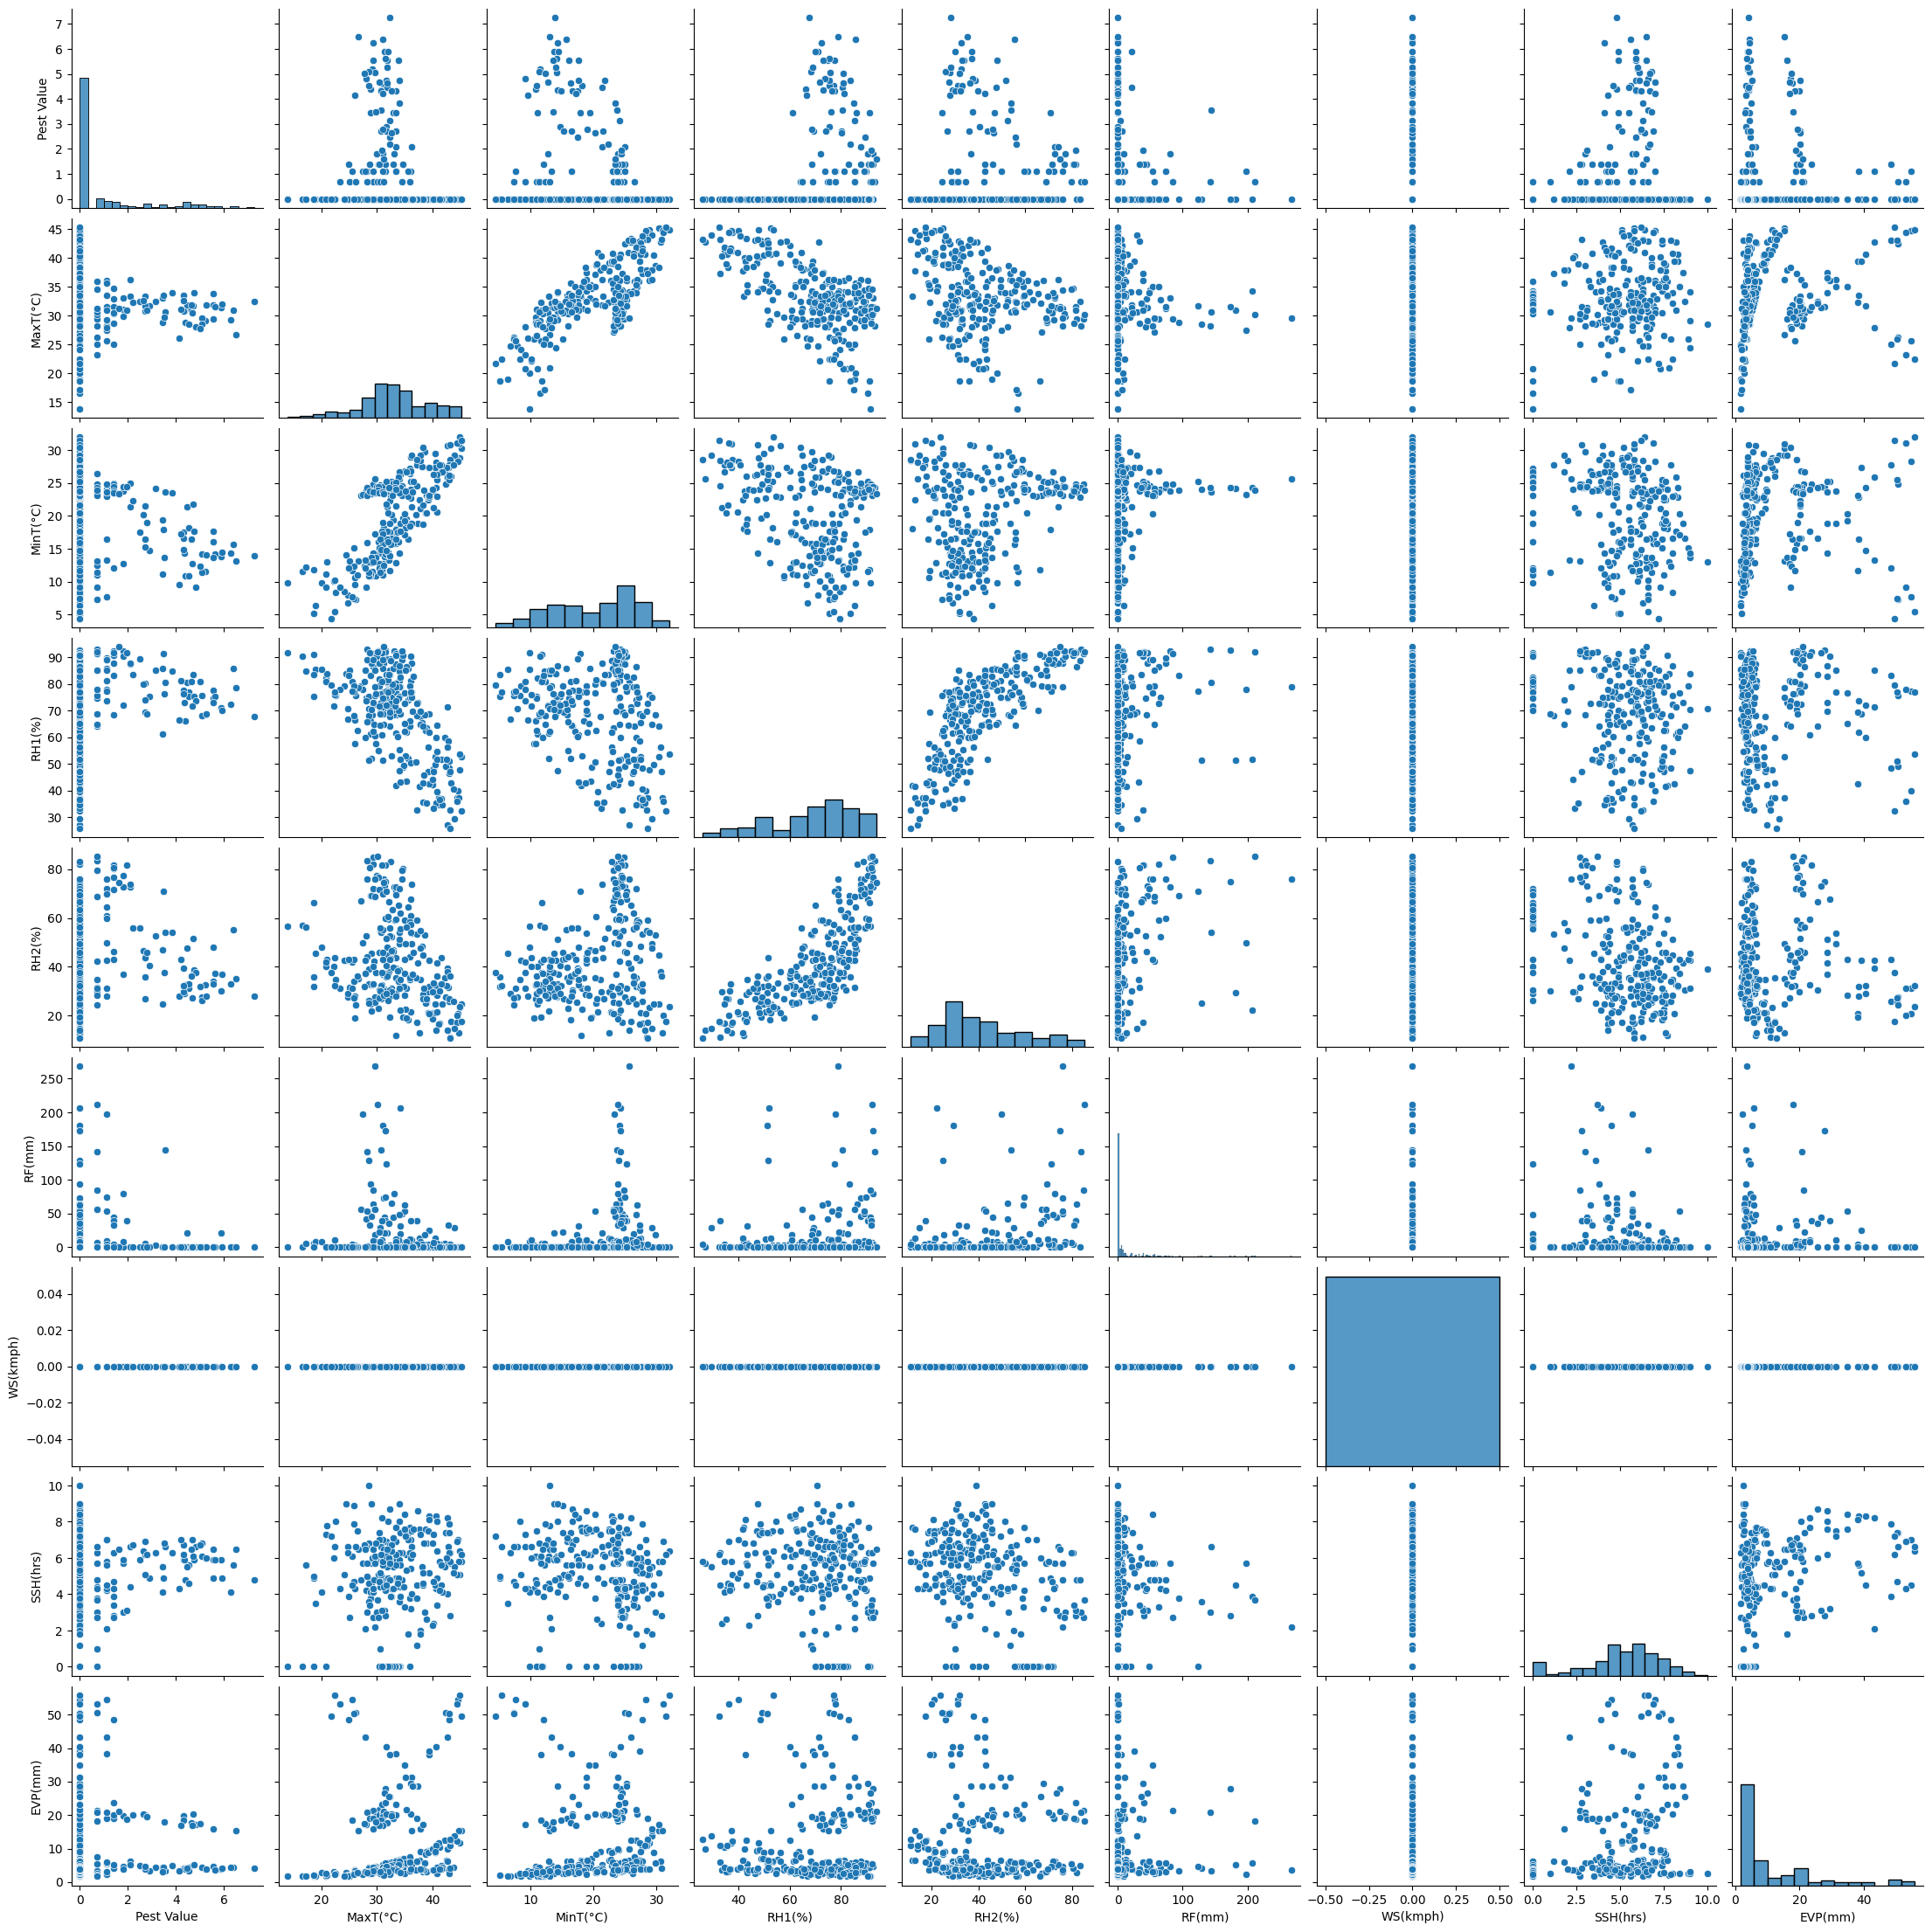

In [ ]:
# Select the relevant columns for the pairplot
relevant_columns = ['Pest Value', 'MaxT(°C)', 'MinT(°C)', 'RH1(%)', 'RH2(%)', 'RF(mm)', 'WS(kmph)', 'SSH(hrs)', 'EVP(mm)']

# Create a pairplot
sns.pairplot(data[relevant_columns])
plt.show()

### Training Models to gauge performance

#### Training a CNN time series predictor which uses only pest Value data to predict future values

In [ ]:
# Preprocess data
scaler = MinMaxScaler()
data['Pest Value'] = scaler.fit_transform(data['Pest Value'].values.reshape(-1, 1))

# Define input features and target labels
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 20  # Number of time steps to look back
X, y = create_dataset(data[['Pest Value']], data['Pest Value'], time_steps=TIME_STEPS)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the CNN model
modelCNN = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(TIME_STEPS, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
modelCNN.compile(optimizer='adam', loss='mse')

# Train the model
modelCNN.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
6/6 [==============================] - 1s 57ms/step - loss: 0.0655 - val_loss: 0.0480
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0430 - val_loss: 0.0433
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0311 - val_loss: 0.0379
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0265 - val_loss: 0.0334
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0220 - val_loss: 0.0300
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0208 - val_loss: 0.0271
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0165 - val_loss: 0.0303
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0160 - val_loss: 0.0289
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0144 - val_loss: 0.0275
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0134 - val_loss: 0.0275
Epoch 11/50
6/6 [================

In [ ]:
# Evaluate the model
loss = modelCNN.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
predictions = modelCNN.predict(X_test)

print(modelCNN.summary())

2/2 [==============================] - 0s 6ms/step - loss: 0.0235
Test Loss: 0.023533470928668976
2/2 [==============================] - 0s 6ms/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 18, 32)            128       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 9, 32)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 288)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                14450     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                     

In [ ]:
# Make predictions using the fitted model
predicted_values = modelCNN.predict(X)

# Calculate residuals
residuals = y - predicted_values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y, predicted_values)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print(f"R-squared score:{r2_score(y, predicted_values)}")

8/8 [==============================] - 0s 5ms/step
Mean Squared Error (MSE): 0.008130387693280049
Root Mean Squared Error (RMSE): 0.09016866247915652
Mean Absolute Error (MAE): 0.05639139697002804
R-squared score:0.8643041430679601


2/2 [==============================] - 0s 6ms/step


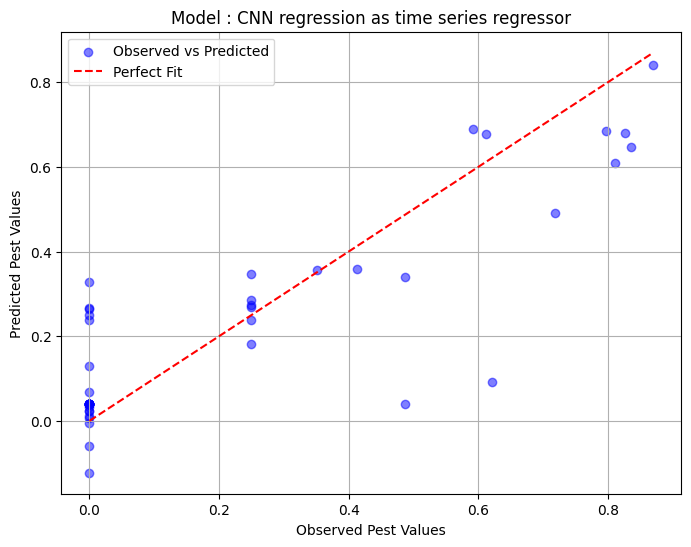

In [ ]:
# Get the observed values from your dataset
observed_values = y_test

# Use the fitted model to predict the Pest Values
predicted_values = modelCNN.predict(X_test)

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.scatter(observed_values, predicted_values, color='blue', label='Observed vs Predicted', alpha=0.5)
plt.plot([min(observed_values), max(observed_values)],[min(observed_values), max(observed_values)], color='red', linestyle='--', label='Perfect Fit')

plt.title('Observed vs Predicted Pest Values')
plt.xlabel('Observed Pest Values')
plt.ylabel('Predicted Pest Values')
plt.title('Model : CNN regression as time series regressor')
plt.legend()
plt.grid(True)
plt.show()

#### Training a CNN using all available parameters to train it as a regressor and predict pest values.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

# Load data
data = pd.read_csv('cotton_dataset.csv')

data['Pest Value'].fillna(0,inplace=True)

pest_value_df = data['Pest Value']

data['Pest Value'] = np.log(data['Pest Value'] + 1 )

# Prepare data
X = data.drop(columns=['Pest Value'], axis=1)
y = data['Pest Value']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for Conv1D
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define the model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))  # Output layer with 1 neuron for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)

y_pred = model.predict(X_test_reshaped)
r2 = r2_score(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

Epoch 1/50
6/6 [==============================] - 1s 40ms/step - loss: 3.0504 - val_loss: 4.2851
Epoch 2/50
6/6 [==============================] - 0s 12ms/step - loss: 2.5087 - val_loss: 4.0762
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 2.3322 - val_loss: 3.8495
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 2.1328 - val_loss: 3.6855
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 1.9951 - val_loss: 3.4807
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 1.8617 - val_loss: 3.2523
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 1.7304 - val_loss: 3.0497
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 1.5975 - val_loss: 2.8627
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 1.4624 - val_loss: 2.7128
Epoch 10/50
6/6 [==============================] - 0s 12ms/step - loss: 1.3462 - val_loss: 2.5935
Epoch 11/50
6/6 [=============

2/2 [==============================] - 0s 5ms/step


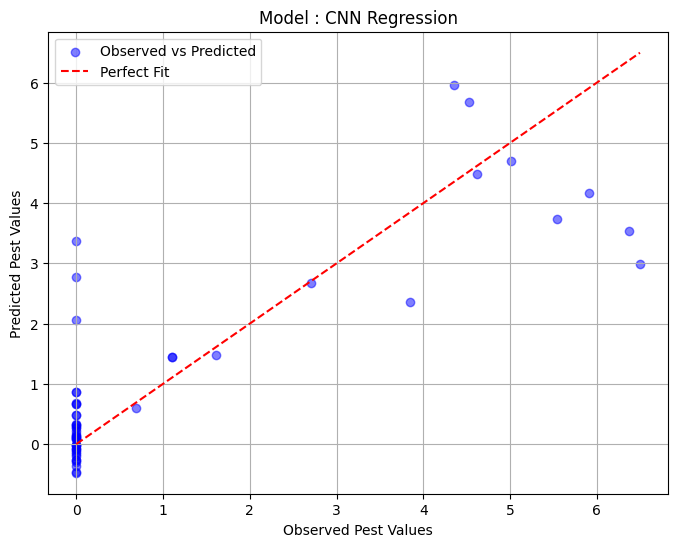

In [ ]:
# Get the observed values from your dataset
observed_values = y_test

# Use the fitted model to predict the Pest Values
predicted_values = model.predict(X_test_reshaped)

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.scatter(observed_values, predicted_values, color='blue', label='Observed vs Predicted', alpha=0.5)
plt.plot([min(observed_values), max(observed_values)],[min(observed_values), max(observed_values)], color='red', linestyle='--', label='Perfect Fit')

plt.title('Observed vs Predicted Pest Values')
plt.xlabel('Observed Pest Values')
plt.ylabel('Predicted Pest Values')
plt.title('Model : CNN Regression')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install shap

#### plotting the importance of the CNN model which utilised the weather parameters to predict the pest value.

1468/1468 [==============================] - 5s 3ms/step


ExactExplainer explainer:   0%|          | 1/208 [00:00<?, ?it/s]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   1%|▏         | 3/208 [00:24<09:08,  2.68s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   2%|▏         | 4/208 [00:27<09:43,  2.86s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   2%|▏         | 5/208 [00:31<11:22,  3.36s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   3%|▎         | 6/208 [00:35<11:08,  3.31s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   3%|▎         | 7/208 [00:38<10:47,  3.22s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   4%|▍         | 8/208 [00:43<13:01,  3.91s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:   4%|▍         | 9/208 [00:46<11:55,  3.60s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   5%|▍         | 10/208 [00:51<13:39,  4.14s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:   5%|▌         | 11/208 [00:55<13:21,  4.07s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   6%|▌         | 12/208 [00:58<12:16,  3.76s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   6%|▋         | 13/208 [01:02<11:48,  3.63s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   7%|▋         | 14/208 [01:05<11:19,  3.50s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   7%|▋         | 15/208 [01:10<13:08,  4.09s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   8%|▊         | 16/208 [01:14<13:15,  4.14s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   8%|▊         | 17/208 [01:20<14:25,  4.53s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   9%|▊         | 18/208 [01:25<15:11,  4.80s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:   9%|▉         | 19/208 [01:28<13:27,  4.27s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  10%|▉         | 20/208 [01:32<13:10,  4.20s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  10%|█         | 21/208 [01:36<12:13,  3.92s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  11%|█         | 22/208 [01:39<11:28,  3.70s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  11%|█         | 23/208 [01:42<11:13,  3.64s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  12%|█▏        | 24/208 [01:46<11:31,  3.76s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  12%|█▏        | 25/208 [01:52<12:55,  4.24s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  12%|█▎        | 26/208 [01:57<13:57,  4.60s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  13%|█▎        | 27/208 [02:01<12:51,  4.26s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  13%|█▎        | 28/208 [02:05<12:27,  4.16s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  14%|█▍        | 29/208 [02:10<13:29,  4.52s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  14%|█▍        | 30/208 [02:13<11:58,  4.04s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  15%|█▍        | 31/208 [02:16<11:19,  3.84s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  15%|█▌        | 32/208 [02:22<12:39,  4.32s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  16%|█▌        | 33/208 [02:27<13:29,  4.63s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  16%|█▋        | 34/208 [02:32<14:03,  4.85s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  17%|█▋        | 35/208 [02:35<12:28,  4.33s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  17%|█▋        | 36/208 [02:39<11:24,  3.98s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  18%|█▊        | 37/208 [02:42<10:51,  3.81s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  18%|█▊        | 38/208 [02:47<11:22,  4.01s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  19%|█▉        | 39/208 [02:52<12:26,  4.42s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  19%|█▉        | 40/208 [02:55<11:17,  4.04s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  20%|█▉        | 41/208 [03:00<12:21,  4.44s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  20%|██        | 42/208 [03:06<13:02,  4.71s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  21%|██        | 43/208 [03:11<13:02,  4.74s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  21%|██        | 44/208 [03:14<11:55,  4.36s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  22%|██▏       | 45/208 [03:17<10:48,  3.98s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  22%|██▏       | 46/208 [03:20<09:58,  3.70s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  23%|██▎       | 47/208 [03:24<10:23,  3.87s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  23%|██▎       | 48/208 [03:28<09:38,  3.62s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  24%|██▎       | 49/208 [03:33<10:59,  4.15s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  24%|██▍       | 50/208 [03:37<10:48,  4.11s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  25%|██▍       | 51/208 [03:40<09:55,  3.80s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  25%|██▌       | 52/208 [03:45<11:04,  4.26s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  25%|██▌       | 53/208 [03:50<11:39,  4.52s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  26%|██▌       | 54/208 [03:54<10:51,  4.23s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  26%|██▋       | 55/208 [03:57<10:10,  3.99s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  27%|██▋       | 56/208 [04:02<10:13,  4.04s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  27%|██▋       | 57/208 [04:05<09:28,  3.76s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  28%|██▊       | 58/208 [04:08<08:46,  3.51s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  28%|██▊       | 59/208 [04:11<08:31,  3.44s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  29%|██▉       | 60/208 [04:16<09:53,  4.01s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  29%|██▉       | 61/208 [04:20<09:17,  3.79s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  30%|██▉       | 62/208 [04:23<08:53,  3.66s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  30%|███       | 63/208 [04:28<10:03,  4.16s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  31%|███       | 64/208 [04:34<10:51,  4.52s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  31%|███▏      | 65/208 [04:37<09:49,  4.12s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  32%|███▏      | 66/208 [04:41<09:48,  4.15s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  32%|███▏      | 67/208 [04:44<09:00,  3.83s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  33%|███▎      | 68/208 [04:47<08:24,  3.61s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  33%|███▎      | 69/208 [04:52<09:34,  4.13s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  34%|███▎      | 70/208 [04:56<09:22,  4.07s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  34%|███▍      | 71/208 [05:00<08:43,  3.82s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  35%|███▍      | 72/208 [05:05<09:42,  4.28s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  35%|███▌      | 73/208 [05:10<10:21,  4.60s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  36%|███▌      | 74/208 [05:14<09:22,  4.20s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  36%|███▌      | 75/208 [05:18<09:08,  4.12s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  37%|███▋      | 76/208 [05:21<08:31,  3.88s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  37%|███▋      | 77/208 [05:24<08:09,  3.74s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  38%|███▊      | 78/208 [05:30<09:08,  4.22s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  38%|███▊      | 79/208 [05:33<08:16,  3.85s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  38%|███▊      | 80/208 [05:36<07:54,  3.70s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  39%|███▉      | 81/208 [05:41<08:57,  4.23s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  39%|███▉      | 82/208 [05:47<09:26,  4.49s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  40%|███▉      | 83/208 [05:52<09:56,  4.77s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  40%|████      | 84/208 [05:57<10:16,  4.97s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  41%|████      | 85/208 [06:03<10:28,  5.11s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  41%|████▏     | 86/208 [06:08<10:34,  5.20s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  42%|████▏     | 87/208 [06:11<09:10,  4.55s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  42%|████▏     | 88/208 [06:17<09:34,  4.79s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  43%|████▎     | 89/208 [06:20<08:29,  4.28s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  43%|████▎     | 90/208 [06:25<09:04,  4.61s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  44%|████▍     | 91/208 [06:31<09:28,  4.86s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  44%|████▍     | 92/208 [06:33<08:17,  4.29s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  45%|████▍     | 93/208 [06:39<08:53,  4.64s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  45%|████▌     | 94/208 [06:44<09:16,  4.88s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  46%|████▌     | 95/208 [06:47<08:08,  4.32s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  46%|████▌     | 96/208 [06:50<07:20,  3.94s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  47%|████▋     | 97/208 [06:56<08:03,  4.36s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  47%|████▋     | 98/208 [07:01<08:34,  4.68s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  48%|████▊     | 99/208 [07:05<07:57,  4.38s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  48%|████▊     | 100/208 [07:09<07:43,  4.29s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  49%|████▊     | 101/208 [07:14<08:13,  4.61s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  49%|████▉     | 102/208 [07:18<07:36,  4.31s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  50%|████▉     | 103/208 [07:23<08:08,  4.65s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  50%|█████     | 104/208 [07:26<07:13,  4.17s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  50%|█████     | 105/208 [07:30<06:39,  3.87s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  51%|█████     | 106/208 [07:35<07:22,  4.34s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  51%|█████▏    | 107/208 [07:40<07:48,  4.64s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  52%|█████▏    | 108/208 [07:46<08:05,  4.85s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  52%|█████▏    | 109/208 [07:51<08:17,  5.02s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  53%|█████▎    | 110/208 [07:56<08:21,  5.12s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  53%|█████▎    | 111/208 [07:59<07:15,  4.49s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  54%|█████▍    | 112/208 [08:03<06:32,  4.09s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  54%|█████▍    | 113/208 [08:08<07:04,  4.47s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  55%|█████▍    | 114/208 [08:11<06:19,  4.03s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  55%|█████▌    | 115/208 [08:16<06:51,  4.43s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  56%|█████▌    | 116/208 [08:22<07:12,  4.70s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  56%|█████▋    | 117/208 [08:25<06:20,  4.18s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  57%|█████▋    | 118/208 [08:30<06:49,  4.56s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  57%|█████▋    | 119/208 [08:35<06:41,  4.52s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  58%|█████▊    | 120/208 [08:39<06:33,  4.47s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  58%|█████▊    | 121/208 [08:44<06:54,  4.77s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  59%|█████▊    | 122/208 [08:50<07:05,  4.95s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  59%|█████▉    | 123/208 [08:53<06:15,  4.42s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  60%|█████▉    | 124/208 [08:58<06:35,  4.71s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  60%|██████    | 125/208 [09:01<05:51,  4.24s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  61%|██████    | 126/208 [09:04<05:16,  3.86s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  61%|██████    | 127/208 [09:08<04:55,  3.65s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  62%|██████▏   | 128/208 [09:11<04:57,  3.72s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  62%|██████▏   | 129/208 [09:14<04:36,  3.50s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  62%|██████▎   | 130/208 [09:20<05:17,  4.08s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  63%|██████▎   | 131/208 [09:24<05:17,  4.13s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  63%|██████▎   | 132/208 [09:27<04:55,  3.89s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  64%|██████▍   | 133/208 [09:31<04:35,  3.67s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  64%|██████▍   | 134/208 [09:34<04:29,  3.65s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  65%|██████▍   | 135/208 [09:40<05:05,  4.18s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  65%|██████▌   | 136/208 [09:43<04:36,  3.84s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  66%|██████▌   | 137/208 [09:48<05:04,  4.29s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  66%|██████▋   | 138/208 [09:51<04:34,  3.92s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  67%|██████▋   | 139/208 [09:56<05:01,  4.37s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  67%|██████▋   | 140/208 [10:01<04:52,  4.30s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  68%|██████▊   | 141/208 [10:06<05:09,  4.61s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  68%|██████▊   | 142/208 [10:09<04:35,  4.18s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  69%|██████▉   | 143/208 [10:14<04:54,  4.53s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  69%|██████▉   | 144/208 [10:18<04:23,  4.12s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  70%|██████▉   | 145/208 [10:21<04:09,  3.95s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  70%|███████   | 146/208 [10:25<04:05,  3.97s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  71%|███████   | 147/208 [10:31<04:28,  4.40s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  71%|███████   | 148/208 [10:34<04:06,  4.10s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  72%|███████▏  | 149/208 [10:38<04:00,  4.08s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  72%|███████▏  | 150/208 [10:42<03:50,  3.98s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  73%|███████▎  | 151/208 [10:47<04:10,  4.40s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  73%|███████▎  | 152/208 [10:53<04:23,  4.70s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  74%|███████▎  | 153/208 [10:58<04:29,  4.90s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  74%|███████▍  | 154/208 [11:03<04:32,  5.04s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  75%|███████▍  | 155/208 [11:06<03:54,  4.43s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  75%|███████▌  | 156/208 [11:12<04:04,  4.71s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  75%|███████▌  | 157/208 [11:17<04:09,  4.90s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  76%|███████▌  | 158/208 [11:20<03:42,  4.45s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  76%|███████▋  | 159/208 [11:24<03:18,  4.06s/it]

31/31 [==============================] - 0s 4ms/step


ExactExplainer explainer:  77%|███████▋  | 160/208 [11:29<03:35,  4.50s/it]

31/31 [==============================] - 0s 6ms/step


ExactExplainer explainer:  77%|███████▋  | 161/208 [11:40<05:03,  6.45s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  78%|███████▊  | 162/208 [11:46<04:45,  6.20s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  78%|███████▊  | 163/208 [11:49<03:56,  5.26s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  79%|███████▉  | 164/208 [11:54<03:53,  5.32s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  79%|███████▉  | 165/208 [11:57<03:19,  4.65s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  80%|███████▉  | 166/208 [12:03<03:24,  4.86s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  80%|████████  | 167/208 [12:08<03:25,  5.01s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  81%|████████  | 168/208 [12:13<03:24,  5.11s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  81%|████████▏ | 169/208 [12:19<03:23,  5.22s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  82%|████████▏ | 170/208 [12:24<03:20,  5.27s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  82%|████████▏ | 171/208 [12:27<02:50,  4.61s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  83%|████████▎ | 172/208 [12:33<02:54,  4.86s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  83%|████████▎ | 173/208 [12:36<02:31,  4.32s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  84%|████████▎ | 174/208 [12:39<02:13,  3.93s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  84%|████████▍ | 175/208 [12:44<02:23,  4.35s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  85%|████████▍ | 176/208 [12:50<02:29,  4.67s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  85%|████████▌ | 177/208 [12:55<02:31,  4.88s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  86%|████████▌ | 178/208 [12:58<02:10,  4.34s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  86%|████████▌ | 179/208 [13:01<01:57,  4.04s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  87%|████████▋ | 180/208 [13:07<02:04,  4.46s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  87%|████████▋ | 181/208 [13:10<01:51,  4.14s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  88%|████████▊ | 182/208 [13:16<01:57,  4.50s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  88%|████████▊ | 183/208 [13:20<01:51,  4.45s/it]

31/31 [==============================] - 0s 1ms/step


ExactExplainer explainer:  88%|████████▊ | 184/208 [13:23<01:38,  4.11s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  89%|████████▉ | 185/208 [13:29<01:43,  4.50s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  89%|████████▉ | 186/208 [13:34<01:42,  4.65s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  90%|████████▉ | 187/208 [13:37<01:28,  4.19s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  90%|█████████ | 188/208 [13:42<01:31,  4.57s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  91%|█████████ | 189/208 [13:46<01:24,  4.42s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  91%|█████████▏| 190/208 [13:52<01:24,  4.71s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  92%|█████████▏| 191/208 [13:55<01:13,  4.34s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  92%|█████████▏| 192/208 [13:59<01:07,  4.24s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  93%|█████████▎| 193/208 [14:02<00:59,  3.96s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  93%|█████████▎| 194/208 [14:06<00:51,  3.71s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  94%|█████████▍| 195/208 [14:09<00:47,  3.65s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  94%|█████████▍| 196/208 [14:15<00:50,  4.19s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  95%|█████████▍| 197/208 [14:20<00:50,  4.57s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  95%|█████████▌| 198/208 [14:24<00:44,  4.49s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  96%|█████████▌| 199/208 [14:28<00:37,  4.12s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  96%|█████████▌| 200/208 [14:31<00:30,  3.82s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  97%|█████████▋| 201/208 [14:36<00:29,  4.28s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  97%|█████████▋| 202/208 [14:40<00:24,  4.07s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  98%|█████████▊| 203/208 [14:43<00:18,  3.78s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer:  98%|█████████▊| 204/208 [14:46<00:14,  3.67s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  99%|█████████▊| 205/208 [14:52<00:12,  4.19s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer:  99%|█████████▉| 206/208 [14:54<00:07,  3.83s/it]

31/31 [==============================] - 0s 3ms/step


ExactExplainer explainer: 100%|█████████▉| 207/208 [14:58<00:03,  3.71s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer: 100%|██████████| 208/208 [15:03<00:00,  4.25s/it]

31/31 [==============================] - 0s 2ms/step


ExactExplainer explainer: 209it [15:06,  4.36s/it]


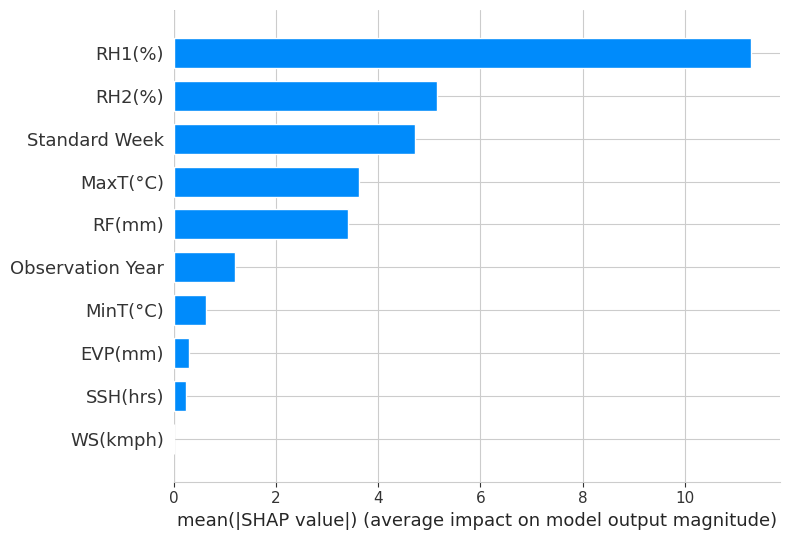

In [ ]:
import shap

# Initialize the SHAP explainer with the model's predict function
explainer = shap.Explainer(model.predict, X_train)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_type='bar')
plt.show()

#### OLS model training and performance summary

In [ ]:
# Fit the regression model
modelOLS = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(modelOLS.summary())
print(X.head())

# Make predictions using the fitted model
predicted_values = modelOLS.predict(X)

# Calculate residuals
residuals = y - predicted_values

print(residuals.shape)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y, predicted_values)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print(f"R-squared score:{r2_score(y, predicted_values)}")

                                 OLS Regression Results                                
Dep. Variable:             Pest Value   R-squared (uncentered):                   0.498
Model:                            OLS   Adj. R-squared (uncentered):              0.480
Method:                 Least Squares   F-statistic:                              27.69
Date:                Wed, 17 Apr 2024   Prob (F-statistic):                    4.72e-33
Time:                        06:50:25   Log-Likelihood:                         -454.22
No. Observations:                 260   AIC:                                      926.4
Df Residuals:                     251   BIC:                                      958.5
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

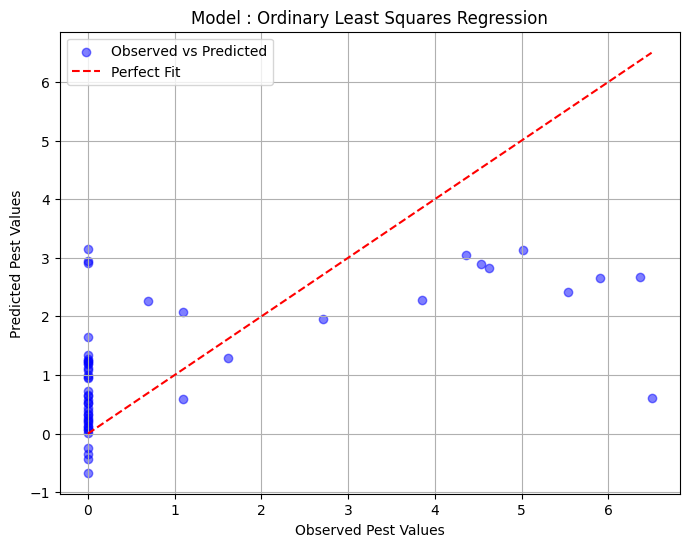

In [ ]:
# Get the observed values from your dataset
observed_values = y_test

# Use the fitted model to predict the Pest Values
predicted_values = modelOLS.predict(X_test)

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.scatter(observed_values, predicted_values, color='blue', label='Observed vs Predicted', alpha=0.5)
plt.plot([min(observed_values), max(observed_values)],[min(observed_values), max(observed_values)], color='red', linestyle='--', label='Perfect Fit')

plt.title('Observed vs Predicted Pest Values')
plt.xlabel('Observed Pest Values')
plt.ylabel('Predicted Pest Values')
plt.title('Model : Ordinary Least Squares Regression')
plt.legend()
plt.grid(True)
plt.show()

#### SVM using RBF kernel testing and training using grid search to optimise model.

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
data = pd.read_csv('cotton_dataset.csv')

data['Pest Value'].fillna(0,inplace=True)

pest_value_df = data['Pest Value']

data['Pest Value'] = np.log(data['Pest Value'] + 1 )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {'C': [0.1, 1, 3, 10],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Create SVM regressor with RBF kernel
svm_regressor = SVR(kernel='rbf')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_regressor, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Optionally, you can also calculate other regression metrics like R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'C': 3, 'gamma': 0.01}
Mean Squared Error: 2.11324866903516
R-squared: 0.4670052425163913


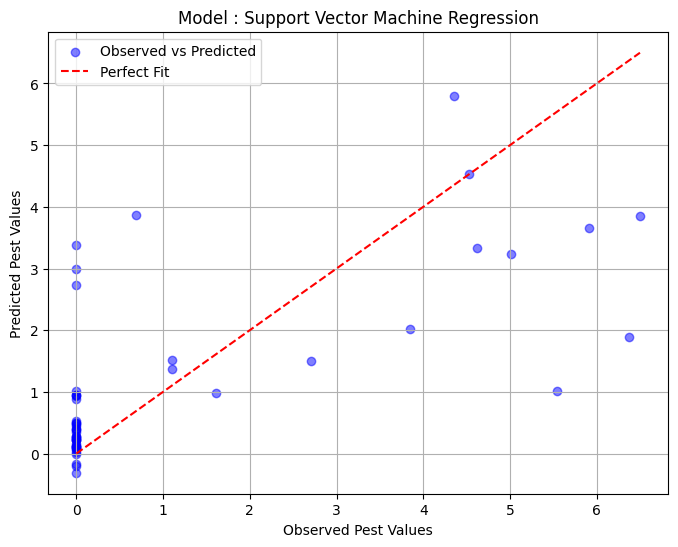

In [ ]:
# Get the observed values from your dataset
observed_values = y_test

# Use the fitted model to predict the Pest Values
predicted_values = grid_search.predict(X_test)

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.scatter(observed_values, predicted_values, color='blue', label='Observed vs Predicted', alpha=0.5)
plt.plot([min(observed_values), max(observed_values)],[min(observed_values), max(observed_values)], color='red', linestyle='--', label='Perfect Fit')

plt.title('Observed vs Predicted Pest Values')
plt.xlabel('Observed Pest Values')
plt.ylabel('Predicted Pest Values')
plt.title('Model : Support Vector Machine Regression')

plt.legend()
plt.grid(True)
plt.show()

#### Linear Regression model analysis

In [ ]:
from sklearn.linear_model import LinearRegression

#data = pd.read_csv('cotton_dataset.csv')

# Select features (independent variables) and target variable (dependent variable)
X = data[['MaxT(°C)', 'MinT(°C)', 'RH1(%)', 'RH2(%)', 'RF(mm)', 'WS(kmph)', 'SSH(hrs)', 'EVP(mm)']]
y = data['Pest Value']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the linear regression model
modelLIN = LinearRegression()
modelLIN.fit(X_train, y_train)

# Make predictions
y_pred = modelLIN.predict(X_test)

# Evaluate the model
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', mean_squared_error(y_test, y_pred, squared=False))
print(f'R-squared Score:{r2_score(y_test, y_pred)}')

# Print the coefficients
coefficients = pd.DataFrame(modelLIN.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

Mean Absolute Error: 1.1291914416983406
Mean Squared Error: 2.1610966278290795
Root Mean Squared Error: 1.4700668786926259
R-squared Score:0.14763064537402038
           Coefficient
MaxT(°C)  1.564059e-01
MinT(°C) -9.357388e-02
RH1(%)    9.412044e-02
RH2(%)   -4.846421e-02
RF(mm)    3.018911e-03
WS(kmph) -1.040834e-17
SSH(hrs)  4.347341e-05
EVP(mm)  -2.909384e-02


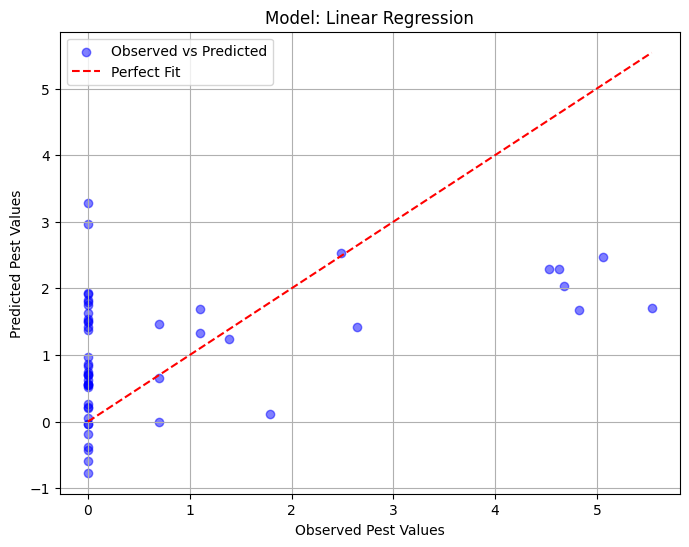

In [ ]:
# Get the observed values from your dataset
observed_values = y_test

# Use the fitted model to predict the Pest Values
predicted_values = modelLIN.predict(X_test)

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.scatter(observed_values, predicted_values, color='blue', label='Observed vs Predicted', alpha=0.5)
plt.plot([min(observed_values), max(observed_values)],[min(observed_values), max(observed_values)], color='red', linestyle='--', label='Perfect Fit')

plt.title('Observed vs Predicted Pest Values')
plt.xlabel('Observed Pest Values')
plt.ylabel('Predicted Pest Values')
plt.title('Model: Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

%matplotlib inline
data = pd.read_excel('Dataset_IML_project.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Observation  Year  260 non-null    int64  
 1   Standard  Week     260 non-null    int64  
 2   Pest  Value        121 non-null    float64
 3   MaxT(°C)           260 non-null    float64
 4   MinT(°C)           260 non-null    float64
 5   RH1(%)             260 non-null    float64
 6   RH2(%)             260 non-null    float64
 7   RF(mm)             260 non-null    float64
 8   WS(kmph)           260 non-null    int64  
 9   SSH(hrs)           260 non-null    float64
 10  EVP(mm)            260 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 22.5 KB


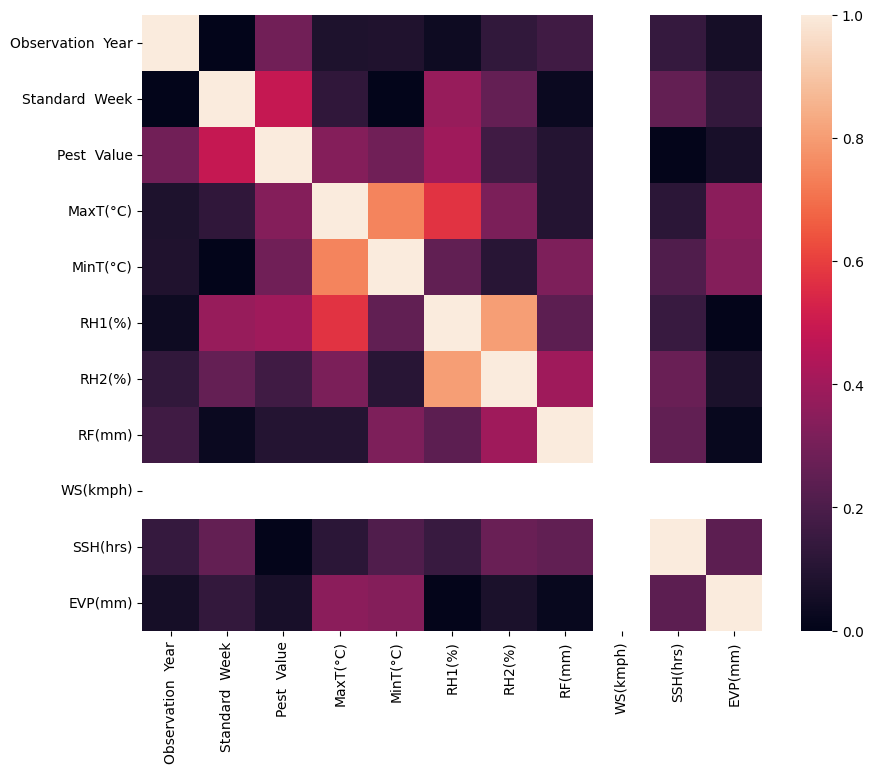

In [ ]:
#impute missing values in Pest value data
data['Pest  Value'].fillna(0,inplace=True)

pest_value_df = data['Pest  Value']

data['Pest  Value'] = np.log(data['Pest  Value'] + 1 )

CorrMatrix = data.corr(method='spearman') # Use spearman for non-linear
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(abs(CorrMatrix), annot=False) # Show absolute value
#plt.show()

# dropping WS column due to high correlation with all parameters
dataDf = data[['Pest  Value', 'MaxT(°C)', 'MinT(°C)', 'RH1(%)', 'RH2(%)', 'RF(mm)', 'SSH(hrs)', 'EVP(mm)']]

In [ ]:
#list of columns for feature selection bar graph
listx1=list(data.columns)[0:2]
listx2=list(data.columns)[3:8]
listx3=list(data.columns)[9:11]
listx= listx1 + listx2 + listx3
listx

['Observation  Year',
 'Standard  Week',
 'MaxT(°C)',
 'MinT(°C)',
 'RH1(%)',
 'RH2(%)',
 'RF(mm)',
 'SSH(hrs)',
 'EVP(mm)']

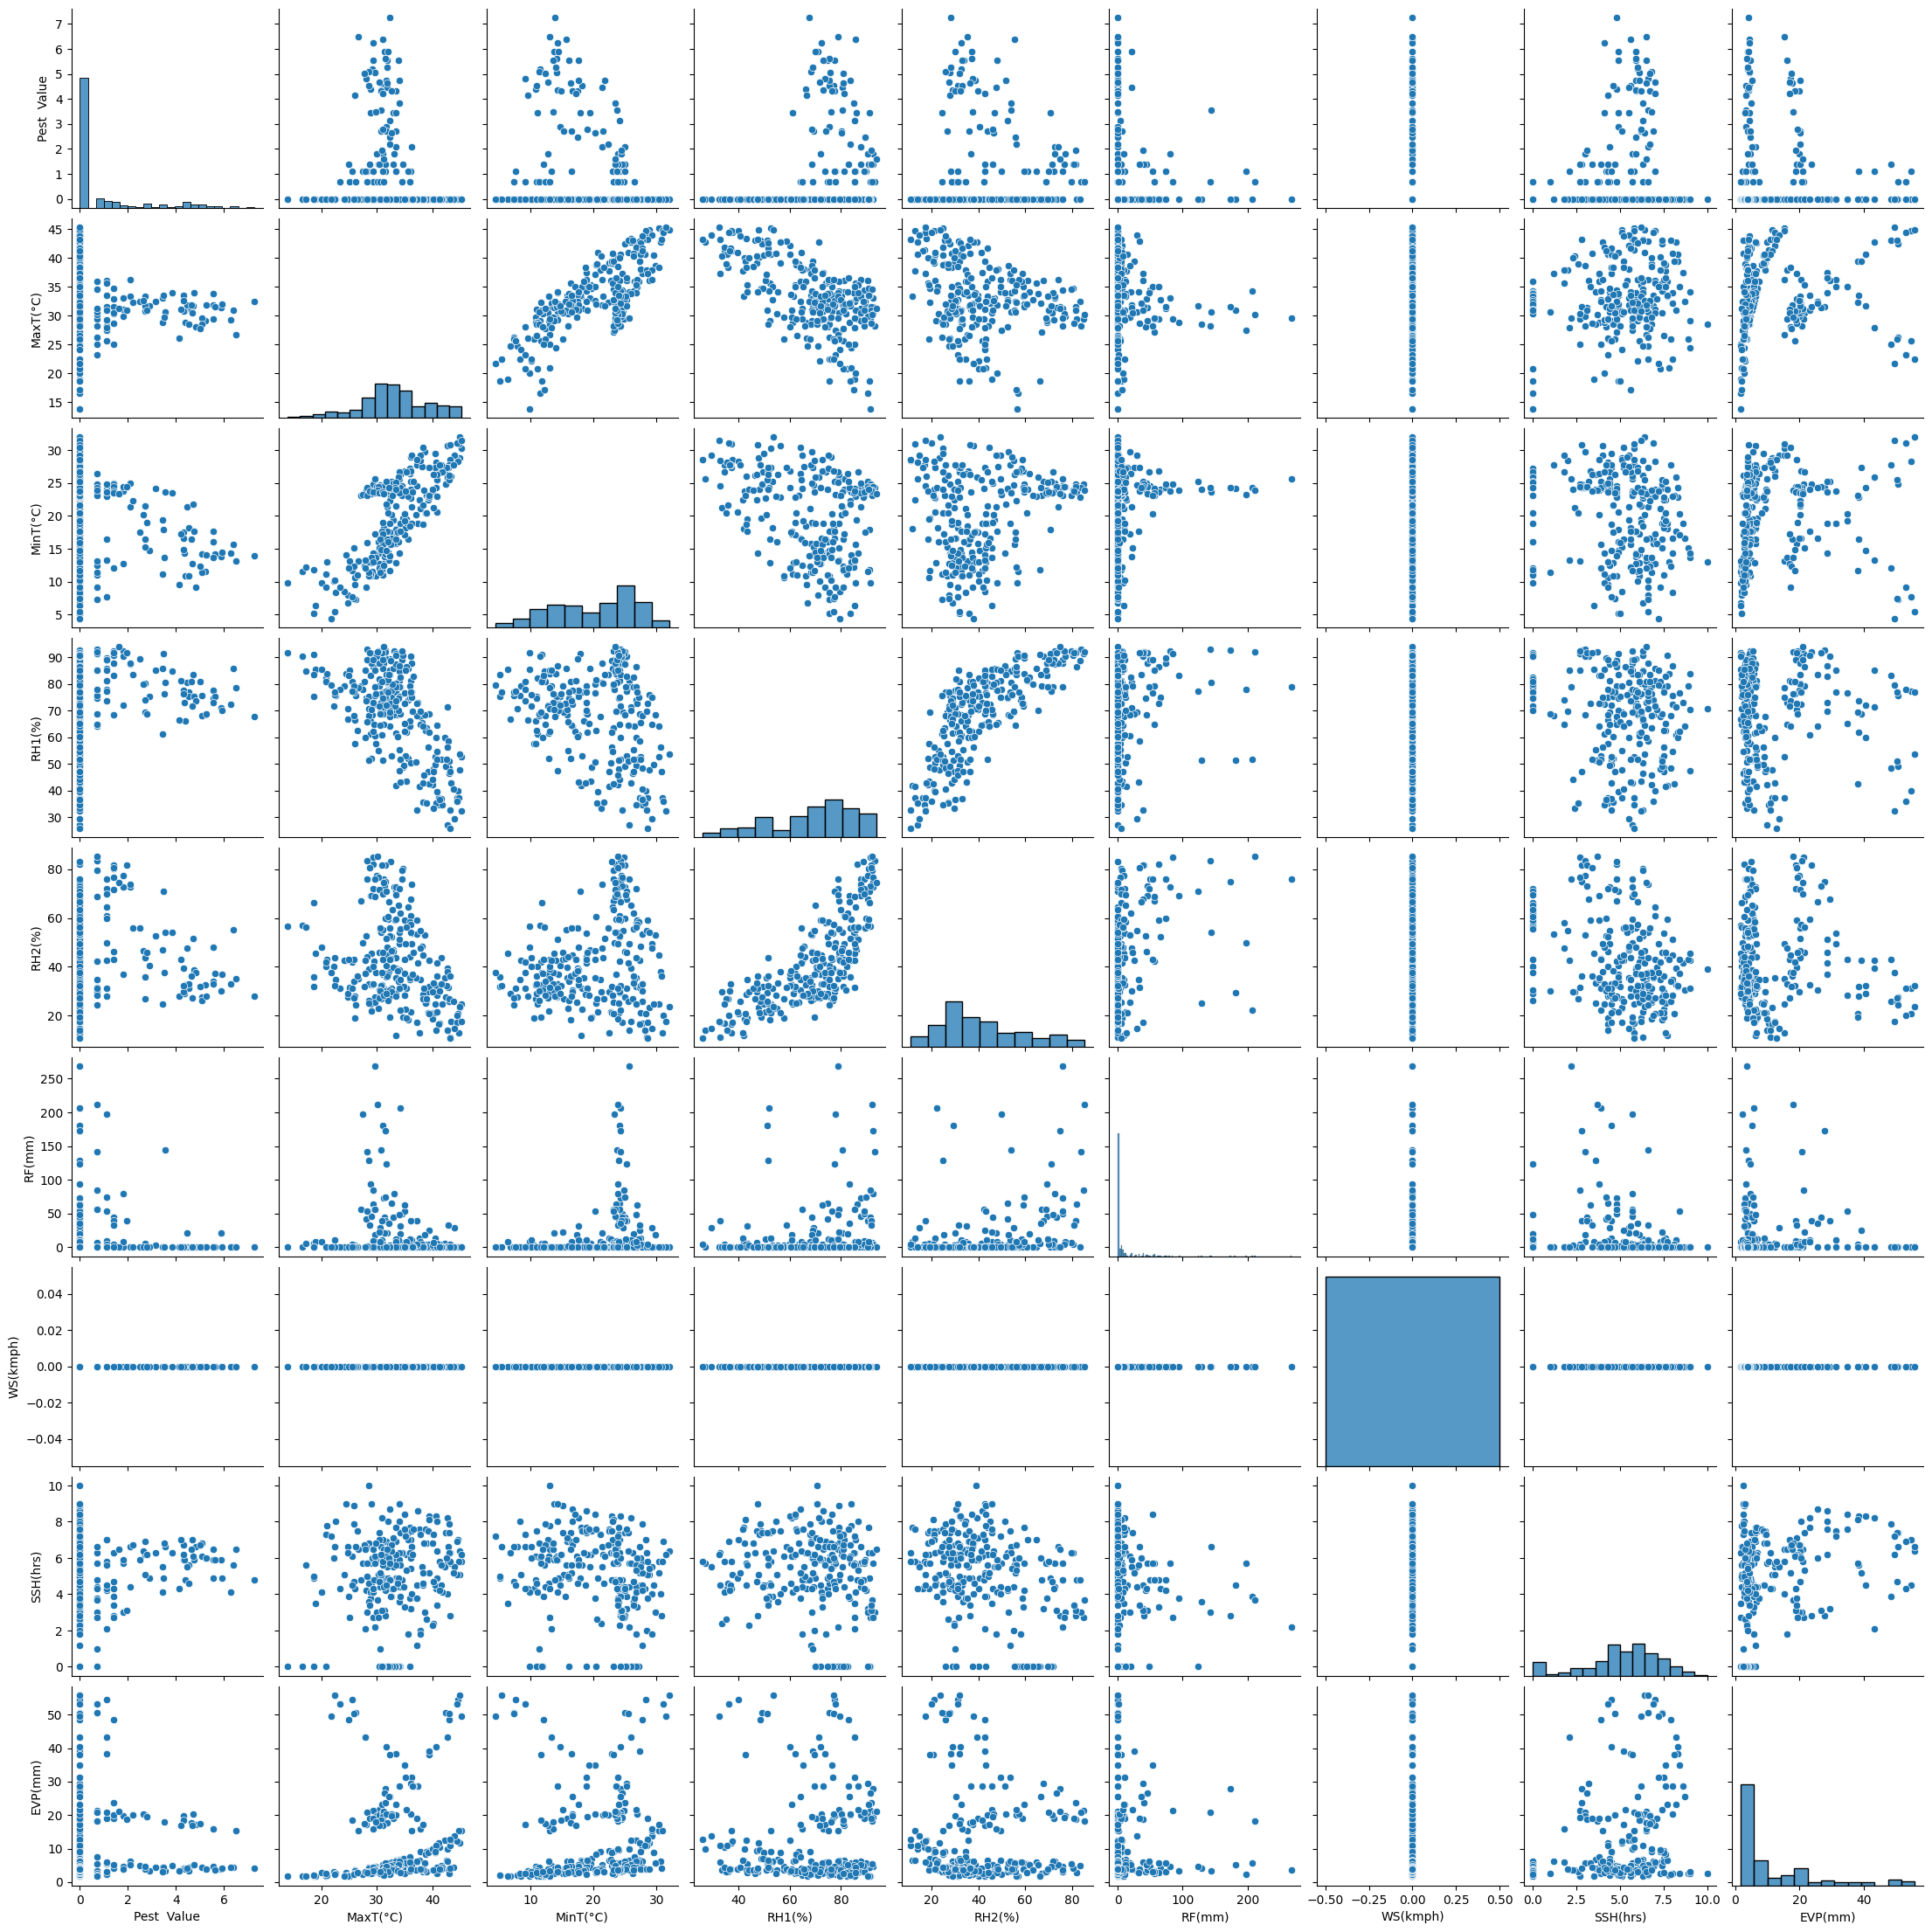

In [ ]:
# Select the relevant columns for the pairplot
relevant_columns = ['Pest  Value', 'MaxT(°C)', 'MinT(°C)', 'RH1(%)', 'RH2(%)', 'RF(mm)', 'WS(kmph)', 'SSH(hrs)', 'EVP(mm)']

# Create a pairplot
sns.pairplot(data[relevant_columns])
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# X_train and X_test should have shape (num_samples, 8) and y_train, y_test should have shape (num_samples, 1)

print(data.columns)

X = data.drop(columns=['WS(kmph)','Pest  Value'],axis=1).values
y = data['Pest  Value'].values

print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can scale your input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Index(['Observation  Year', 'Standard  Week', 'Pest  Value', 'MaxT(°C)',
       'MinT(°C)', 'RH1(%)', 'RH2(%)', 'RF(mm)', 'WS(kmph)', 'SSH(hrs)',
       'EVP(mm)'],
      dtype='object')
(260, 9) (260,)


In [ ]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# creating a RF classifier
clf = RandomForestRegressor(n_estimators = 50)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(X_test)

In [ ]:
# Evaluating the model
# Calculate residuals
residuals = y_test - y_pred

print(residuals.shape)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print(f"R-squared score:{r2_score(y_test, y_pred)}")

(52,)
Mean Squared Error (MSE): 0.8582882566070669
Root Mean Squared Error (RMSE): 0.926438479666657
Mean Absolute Error (MAE): 0.5352777083039595
R-squared score:0.7835261188688336


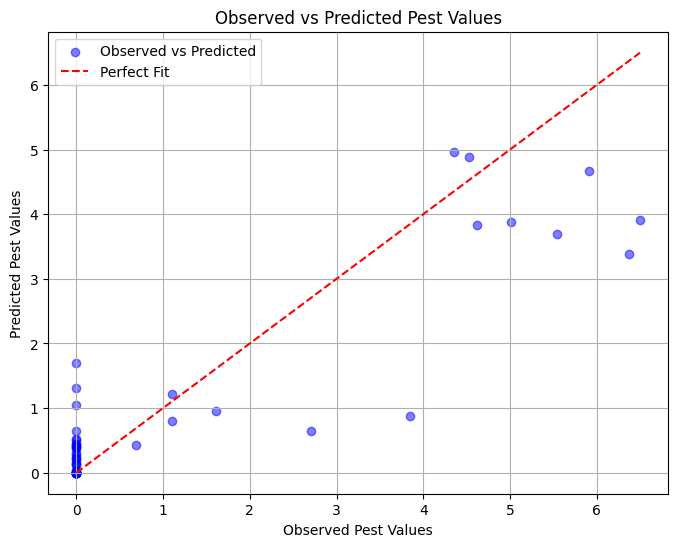

In [ ]:
# Get the observed values from your dataset
observed_values = y_test

# Use the fitted model to predict the Pest Values
predicted_values = y_pred

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.scatter(observed_values, predicted_values, color='blue', label='Observed vs Predicted', alpha=0.5)
plt.plot([min(observed_values), max(observed_values)],[min(observed_values), max(observed_values)], color='red', linestyle='--', label='Perfect Fit')

plt.title('Observed vs Predicted Pest Values')
plt.xlabel('Observed Pest Values')
plt.ylabel('Predicted Pest Values')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

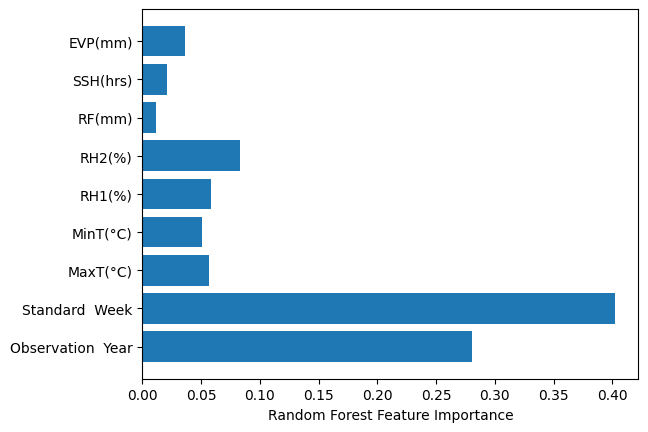

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

clf.feature_importances_

#Plotting Bargraph of Feature Importance
plt.barh(listx, clf.feature_importances_)
plt.xlabel("Random Forest Feature Importance")